<a href="https://colab.research.google.com/github/jah1994/PyTorchDIA/blob/master/PyTorch_DIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Brief description**

A GPU accelerated approach for fast kernel (and differential background) solutions. The model image proposed in the Bramich (2008) algorithm is analogous to a very simple CNN, with a single convolutional layer / discrete pixel array (i.e. the kernel) and an added scalar bias (i.e. the differential background). We do not solve for the discrete pixel array directly in the linear least-squares sense. Rather, by making use of PyTorch tensors (GPU compatible multi-dimensional matrices) and neural network architecture, we solve via an efficient gradient-descent directed optimisation. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# make sure to enable GPU acceleration! (Tesla K80 GPU)
device = 'cuda'

In [0]:
import torch
import numpy as np
from astropy.io.fits import getdata
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv

# Crop edges from resampled images if necessary
crop = 10
# specify kernel size
ks = 31
# padding required to ensure ouput retains input dimensions
pw = 15

def convert_to_tensor(data):
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

def infer_kernel(R, I, maxiter):
        
    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1,
                        out_channels=1,
                        groups = 1,
                        kernel_size=ks,
                        padding = pw,
                        padding_mode = 'zeros',
                        bias=True)
    )
    '''
    'Hand-written' alternative model
    '''
    '''
    class model(torch.nn.Module):
        def __init__(self):

            super(my_model, self).__init__()
            self.conv = torch.nn.Conv2d(in_channels=1,
                            out_channels=1,
                            kernel_size=ks,
                            padding = pw,
                            padding_mode = 'zeros',
                            bias=False)
            self.b = torch.nn.Parameter(torch.ones(1))

        def forward(self, x):

            #y_pred =  self.conv(x) + self.b
            y_pred = torch.add(self.conv(x), self.b)
            return y_pred
    '''
    # Initialise kernel weights + bias
    model[0].weight = torch.nn.Parameter(1e-3* torch.ones(model[0].weight.shape, requires_grad=True))
    model[0].bias = torch.nn.Parameter(1* torch.ones(model[0].bias.shape, requires_grad=True))
    
    # Move model to GPU
    model = model.to(device)

    # Define the loss (our scalar objective function to optimise)
    # Sometimes referred to as the 'cost' in the ML literature
    # Here I use simply the MSE loss i.e. (data - model)^2
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    # Keep track of the speed to convergence for development's sake
    losses = []
    ts = []

    # Optimize with the 'Adam' algorithm.
    # See https://arxiv.org/abs/1609.04747 for review + recommendations
    # of this and other gradient descent optimization algorithms
    # N.B. the choice of two different learning rates for the bias and
    # and convolutional layer
    optimizer = torch.optim.Adam([
                {'params': model[0].weight, 'lr': 1e-3},
                {'params': model[0].bias, 'lr': 1} 
            ])
    
    # Time the optimisation
    import time
    start_time = time.time()

    for t in range(maxiter):
        y_pred = model(R)
        loss = loss_fn(y_pred, I)
        if t % 100 == 99:
            print(t, loss.item())
        losses.append(loss)
        ts.append(t)
        # Heuristic convergence condition
        if t>2 and (1 - abs(losses[-1]/losses[-2])) < 1e-4:
                break
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    '''
    Can compare Adam against LBFGS. For this problem, I've found
    Adam to hit convergence (slightly) faster.
    '''
    '''
    # optimisation w. LBFGS
    learning_rate = 1.
    optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    for i in range(maxiter):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            y_pred = model(R)
            loss = loss_fn(y_pred, I)
            #print('loss:', loss.item())
            loss.backward()
            return loss
        
        optimizer.step(closure)
    '''

    print("--- Finished in %s seconds ---" % (time.time() - start_time))
    
    plt.plot(ts[1:], np.log(losses[1:]))
    plt.xlabel('Iterations')
    plt.ylabel('log_10(loss)')
    plt.title('log loss vs iterations')
    plt.show()
        
    inferred_kernel = model[0].weight
    inferred_kernel = inferred_kernel[0][0].cpu().detach().numpy()
    inferred_bkgr = model[0].bias
    inferred_bkgr = inferred_bkgr.cpu().detach().numpy()
    print('B_0:', inferred_bkgr)
    print('Photometric scale factor', np.sum(inferred_kernel))
    return inferred_kernel , inferred_bkgr




<Figure size 360x360 with 0 Axes>

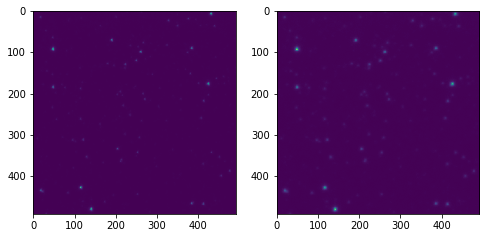

99 69124423680.0
199 53610749952.0
299 50472214528.0
399 49306025984.0
--- Finished in 4.8284995555877686 seconds ---


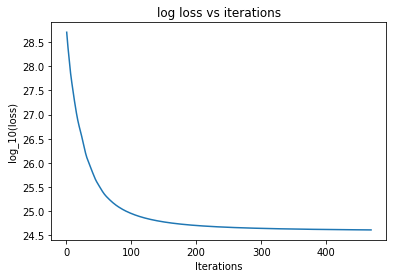

B_0: [-68.265976]
Photometric scale factor 1.015602


In [4]:
import os

# Load test datasets

path = '/content/drive/My Drive'

# Microlensing field (LI 512x512) - no known event
#R = os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.stack.fits')
#I = os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-19_00000.stack.fits')

# Microlensing field (LI 512x512) - lensed target
R = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-14_00129.fits')
I = os.path.join(path, 'coll_LOB190560Z_Llr_2019-05-10_00107.fits')

# 
#R = os.path.join(path, 'lsc1m005-fl15-20170725-0100-e91.fits')
#I = os.path.join(path, 'lsc1m005-fa15-20190416-0242-e91.fits')


# Load fits files
R = getdata(R, 0, header=True)[0]
I = getdata(I, 0, header=True)[0]
# Apply the crops if specified
R = R[crop:R.shape[0]-crop, crop:R.shape[1]-crop]
I = I[crop:I.shape[0]-crop, crop:I.shape[1]-crop]

# Display R and I
plt.figure(figsize=(5,5))
f, axarr = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(8)
axarr[0].imshow(R)
axarr[1].imshow(I)
plt.show()

# 'sky' subtract images (OK for LI!)
R -= np.median(R)
I -= np.median(I)

# Convert 2D numpy arrays [H, W] to 4D torch tensors [batch, channels, H, W]
R, I = convert_to_tensor(R), convert_to_tensor(I)

# Move to GPU
R = R.to(device)
I = I.to(device)

kernel, B0 = infer_kernel(R, I, maxiter=1000)

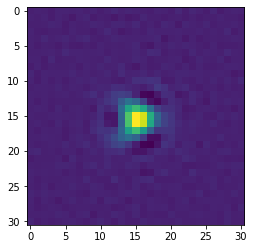

"\nfrom astropy.io import fits\n\nhdu = fits.PrimaryHDU(kernel)\nhdul = fits.HDUList([hdu])\nhdul.writeto(os.path.join(path, 'kernel_correct.fits'))\n"

In [5]:
# Flip and plot kernel before passing to convolve2d()
# and optionally save as fits file
kernel = np.flip(np.flip(kernel, 0), 1)
plt.imshow(kernel)
plt.show()
'''
from astropy.io import fits

hdu = fits.PrimaryHDU(kernel)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 'kernel_correct.fits'))
'''

In [6]:
# Detach R and I from GPU
R = R[0][0].cpu().detach().numpy()
I = I[0][0].cpu().detach().numpy()
print(R.shape, I.shape)

(492, 492) (492, 492)


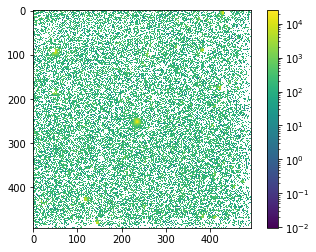

In [7]:
# Convolve R with inferred kernel, add B0,
# subtract I and plot the difference image
from scipy.signal import convolve2d
from matplotlib.colors import LogNorm
M = convolve2d(R, kernel, mode='same') + B0
D = M - I
plt.imshow(D, norm=LogNorm())
plt.colorbar()

The difference image looks OK, but the PSF is clearly non constant around the image boundaries.
Check branches for implemetation solving for image sub-regions in an iterative (i.e. weighted) manner.

In [0]:
# Optionally save the output
'''
from astropy.io import fits

hdu = fits.PrimaryHDU(D)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 'subtraction_correct2.fits'))
'''